In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
#import org.apache.spark.sql.SparkSession
from pymongo import MongoClient
from pyspark import SparkContext
from pyspark.sql import Row
import pandas as pd
import numpy as np
from pyspark.sql.functions import dayofyear,year
from pyspark.sql.functions import round, col
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

In [2]:
spark = SparkSession.builder.appName("Amazon1").config("spark.mongodb.input.uri", "mongodb://127.0.0.1:27017/Amazon.mycollection")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1:27017/Amazon.mycollection")\
        .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:10.1.1')\
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "4g") \
        .config("spark.executor.cores", "4") \
        .config("spark.sql.shuffle.partitions", "8") \
        .config('spark.driver.host', 'localhost').getOrCreate()


Picked up _JAVA_OPTIONS: -Xmx3000m
Picked up _JAVA_OPTIONS: -Xmx3000m


:: loading settings :: url = jar:file:/home/hadoop/.local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8a66f785-79fb-4c95-9581-e0e5c2de03b5;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;10.1.1 in central
	found org.mongodb#mongodb-driver-sync;4.8.2 in central
	[4.8.2] org.mongodb#mongodb-driver-sync;[4.8.1,4.8.99)
	found org.mongodb#bson;4.8.2 in central
	found org.mongodb#mongodb-driver-core;4.8.2 in central
	found org.mongodb#bson-record-codec;4.8.2 in central
:: resolution report :: resolve 9141ms :: artifacts dl 8ms
	:: modules in use:
	org.mongodb#bson;4.8.2 from central in [default]
	org.mongodb#bson-record-codec;4.8.2 from central in [default]
	org.mongodb#mongodb-driver-core;4.8.2 from central in [default]
	org.mongodb#mongodb-driver-sync;4.8.2 from central in [default]
	org.mongodb.spark#mongo-spark-connector_

In [3]:
df = spark.read.format("mongodb").option("uri", "mongodb://127.0.0.1:27017/").option("database", "Amazon").option("collection", "mycollection").load();

In [4]:
df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color Name:: string (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Configuration:: string (nullable = true)
 |    |-- Connectivity:: string (nullable = true)
 |    |-- Digital Storage Capacity:: string (nullable = true)
 |    |-- Edition:: string (nullable = true)
 |    |-- Flavor:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Item Package Quantity:: string (nullable = true)
 |    |-- Length:: string (nullable = true)
 |    |-- Material Type:: string (nullable = true)
 |    |-- Number of Items:: string (nullable = true)


In [4]:
#making another dataframe in which we are taking only the seemingly useful values
df1 = df.drop("style","image")

In [20]:
df1.show()

+--------------------+----------+-------+--------------------+-----------+--------------+----------------+--------------------+--------------+--------+----+
|                 _id|      asin|overall|          reviewText| reviewTime|    reviewerID|    reviewerName|             summary|unixReviewTime|verified|vote|
+--------------------+----------+-------+--------------------+-----------+--------------+----------------+--------------------+--------------+--------+----+
|6458e90601ecb8d65...|B017O9P72A|    1.0|Weak!!\n\nAlexa d...| 12 7, 2015| ACCQIOZMFN4UK|        Da-Gr8-1|         Time waster|    1449446400|   false|  11|
|6458e90601ecb8d65...|B017O9P72A|    5.0|         Great skill|01 15, 2018|A3TXR8GLKS19RE|           Nello|               Great|    1515974400|   false|null|
|6458e90601ecb8d65...|B017O9P72A|    1.0|Pretty crappy. Wo...| 01 5, 2018| AVIWE1LJXCG77|    Pete Johnson|        Returning to|    1515110400|   false|   4|
|6458e90601ecb8d65...|B017O9P72A|    1.0|Can not connect a

In [5]:
#Converting the vote column into an integer column so we can use it for analysis
df1 = df1.withColumn("vote", col("vote").cast("integer"))

In [6]:
df1.printSchema()

root
 |-- _id: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: integer (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: integer (nullable = true)



In [14]:
#reviewtime analysis, overall analysis, verified analysis


# EDA

In [6]:
#Taking a sample of the dataframe
sampled_df = df1.sample(withReplacement=False, fraction=0.1, seed=42)

In [10]:
sampled_df.show()

+--------------------+----------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------+--------+----+
|                 _id|      asin|overall|          reviewText| reviewTime|    reviewerID|       reviewerName|             summary|unixReviewTime|verified|vote|
+--------------------+----------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------+--------+----+
|6458e90601ecb8d65...|B017O9P72A|    5.0|So easy to connec...|12 25, 2017|A3KWZMO1A9TO3Z|    Amazon Customer|     This is awesome|    1514160000|   false|   2|
|6458e90601ecb8d65...|B017O9P72A|    5.0|I haven't had any...|11 24, 2017|A2LNJJWW2TLL00|            jarhead|            Love it!|    1511481600|   false|null|
|6458e90601ecb8d65...|B017O9P72A|    1.0|The title says it...|07 23, 2017|  A9Z810V4E39P|            RobertP|Update breaks fun...|    1500768000|   false|   2|
|6458e90601ecb8d65...|B017O9P72A|    3.0

In [21]:
#showing only verified reviews to get rid of fake reviews
sampled_df.select('_id','asin','reviewerID', 'unixReviewTime', 'vote', 'verified').filter(sampled_df.verified=='true').show()

+--------------------+----------+--------------+--------------+----+--------+
|                 _id|      asin|    reviewerID|unixReviewTime|vote|verified|
+--------------------+----------+--------------+--------------+----+--------+
|6458e90701ecb8d65...|B000HA3CEY|A1U4R8DP7MLOYP|    1354060800|   6|    true|
|6458e90701ecb8d65...|B001EJZNXK|A11AP8Z9IF3NH2|    1361836800|null|    true|
|6458e90701ecb8d65...|B001EJY2IC| AZVVZKY2DQU81|    1426723200|null|    true|
|6458e90701ecb8d65...|B001EJY2IC| ADD10E6HUUQ5J|    1426118400|null|    true|
|6458e90701ecb8d65...|B001GC0FLA|A1ASWATMCFI8R1|    1341014400|null|    true|
|6458e90701ecb8d65...|B001GC0FLA|A3M8WD1HIR3FG1|    1341014400|null|    true|
|6458e90701ecb8d65...|B002DHESLU| AETKF4ZMLZV0W|    1512950400|null|    true|
|6458e90701ecb8d65...|B002DHESLU|A2J09IQGL17GO0|    1482969600|null|    true|
|6458e90701ecb8d65...|B002DHESLU| A7MPXXSXRMUN7|    1501804800|null|    true|
|6458e90701ecb8d65...|B002DHESLU|A3FNYJGNMSIM8U|    1429228800| 

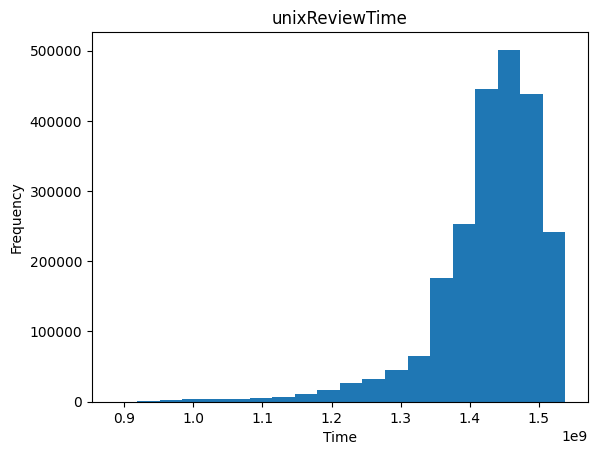

In [25]:
#visual representation of the unixReviewTime column. 
#The resulting plot shows the distribution of review times in the dataset
#with the x-axis showing the time values and the y-axis showing the frequency of reviews in each time bin.

col_name = "unixReviewTime"
values = sampled_df.select(col_name).rdd.flatMap(lambda x: x).collect()
plt.hist(values, bins=20)
plt.title(col_name)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [7]:
resampled_df = sampled_df.sample(withReplacement=False, fraction=0.1, seed=42)

In [11]:
resampled_df.show()

+--------------------+----------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+--------+----+
|                 _id|      asin|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|verified|vote|
+--------------------+----------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+--------+----+
|6458e90701ecb8d65...|B001EJY2IC|    5.0|              A+++++|03 19, 2015| AZVVZKY2DQU81|      Ernest C. Lowe|    Better container|    1426723200|    true|null|
|6458e90701ecb8d65...|B002DHESLU|    5.0|Its a beautiful c...|04 17, 2015|A3FNYJGNMSIM8U|              edward|     would recommend|    1429228800|    true|   7|
|6458e90701ecb8d65...|B0058OQWH8|    5.0|All pennies were ...| 05 3, 2018| AEQD68FVQVLMD|                Brad|          Five Stars|    1525305600|    true|null|
|6458e90701ecb8d65...|B00BF2L4FW| 

In [8]:
#Only taking into account verified reviewers as to get rid of fake reviews
resampled_df = resampled_df.filter(col('verified') == True)

# Machine Learning

In [9]:
#making a seperate df for machine learning and removing columns that are'nt necessary for the model

ml_df = resampled_df.drop("reviewerName","reviewText", "reviewTime", "summary", "unixReviewTime", "verified", "vote")

In [10]:
ml_df.show()

+--------------------+----------+-------+--------------+
|                 _id|      asin|overall|    reviewerID|
+--------------------+----------+-------+--------------+
|6458e90701ecb8d65...|B001EJY2IC|    5.0| AZVVZKY2DQU81|
|6458e90701ecb8d65...|B002DHESLU|    5.0|A3FNYJGNMSIM8U|
|6458e90701ecb8d65...|B0058OQWH8|    5.0| AEQD68FVQVLMD|
|6458e90701ecb8d65...|B00BF2L4FW|    5.0|A1XE7VUKILTR9O|
|6458e90701ecb8d65...|B00CFCKJ0W|    5.0|A1QTJU4R9CS8PH|
|6458e90701ecb8d65...|B00414KZJC|    5.0|A37EBM6VN2UBAL|
|6458e90701ecb8d65...|B00LABXYGA|    5.0| APHF7JDEYIIS7|
|6458e90701ecb8d65...|B00LAGBNYK|    5.0|A3OVE1Z1LLK3CU|
|6458e90701ecb8d65...|B00LAGCDR6|    5.0|A1OUYPFLIOMUKL|
|6458e90701ecb8d65...|B00YQ4WGUS|    5.0|A28VJUFY3YZWKP|
|6458e90701ecb8d65...|B00J9P3KBS|    1.0| A4UMCUYW2O89L|
|6458e90701ecb8d65...|B00J9P3KBS|    4.0|A3L3ETMBSVUY8T|
|6458e90701ecb8d65...|B004JJGLHO|    4.0|A1JSXUF2N9BELC|
|6458e90701ecb8d65...|B004JJGLHO|    4.0|A2GXHCJKDT2B35|
|6458e90701ecb8d65...|B004UMZ30

In [11]:
ml_df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- overall: double (nullable = true)
 |-- reviewerID: string (nullable = true)



# ASL

In [12]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Convert the reviewerID and asin columns to numeric using StringIndexer
reviewer_id_indexer = StringIndexer(inputCol="reviewerID", outputCol="userId").setHandleInvalid("skip")
asin_indexer = StringIndexer(inputCol="asin", outputCol="itemId").setHandleInvalid("skip")
mldf_indexed = reviewer_id_indexer.fit(ml_df).transform(ml_df)
mldf_indexed = asin_indexer.fit(mldf_indexed).transform(mldf_indexed)



23/05/14 00:14:13 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
23/05/14 00:14:57 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
23/05/14 00:16:03 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


In [13]:
mldf_indexed.show()

23/05/14 00:16:06 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


+--------------------+----------+-------+--------------+--------+------+
|                 _id|      asin|overall|    reviewerID|  userId|itemId|
+--------------------+----------+-------+--------------+--------+------+
|6458e90701ecb8d65...|B001EJY2IC|    5.0| AZVVZKY2DQU81|192500.0|4164.0|
|6458e90701ecb8d65...|B002DHESLU|    5.0|A3FNYJGNMSIM8U|125595.0|4888.0|
|6458e90701ecb8d65...|B0058OQWH8|    5.0| AEQD68FVQVLMD|163514.0|6241.0|
|6458e90701ecb8d65...|B00BF2L4FW|    5.0|A1XE7VUKILTR9O| 50922.0|7307.0|
|6458e90701ecb8d65...|B00CFCKJ0W|    5.0|A1QTJU4R9CS8PH| 41898.0|7469.0|
|6458e90701ecb8d65...|B00414KZJC|    5.0|A37EBM6VN2UBAL|114140.0|5524.0|
|6458e90701ecb8d65...|B00LABXYGA|    5.0| APHF7JDEYIIS7|178155.0|8615.0|
|6458e90701ecb8d65...|B00LAGBNYK|    5.0|A3OVE1Z1LLK3CU|138275.0|8616.0|
|6458e90701ecb8d65...|B00LAGCDR6|    5.0|A1OUYPFLIOMUKL| 39262.0|8617.0|
|6458e90701ecb8d65...|B00YQ4WGUS|    5.0|A28VJUFY3YZWKP| 66609.0|9683.0|
|6458e90701ecb8d65...|B00J9P3KBS|    1.0| A4UMCUYW2

In [14]:
# Splitting the data into training and testing sets
(training, test) = mldf_indexed.randomSplit([0.8, 0.2])

# Creating an instance of the ALS model
als = ALS(userCol="userId", itemCol="itemId", ratingCol="overall", coldStartStrategy="drop")



In [15]:
# Training the ALS model on the training data
model = als.fit(training)

23/05/14 00:16:12 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:16:13 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:17:46 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:17:55 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:17:55 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:18:03 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:18:04 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:18:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/14 00:18:05 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:18:05 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/05/14 00:18:05 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14

In [16]:
# Generating predictions on the test data
predictions = model.transform(test)

In [17]:
predictions.show()

23/05/14 00:18:22 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:18:23 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:18:23 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


+--------------------+----------+-------+--------------+--------+------+------------+
|                 _id|      asin|overall|    reviewerID|  userId|itemId|  prediction|
+--------------------+----------+-------+--------------+--------+------+------------+
|6458e94301ecb8d65...|B0014CSIG6|    5.0|A2V4OIE960OZP1| 97053.0|3595.0|    4.950967|
|6458e96201ecb8d65...|B00S9RPGZU|    1.0| AM67N4I601TWQ|173642.0|1063.0|   0.8998626|
|6458e97401ecb8d65...|B004JNU22A|    4.0|A2NTAJWH2U13XJ| 87094.0|5833.0|   3.9349976|
|6458e97401ecb8d65...|B0006GVNOA|    5.0|A2LDP3A4IE9T6T| 83837.0|   6.0|    4.948071|
|6458e98301ecb8d65...|B006LXOJC0|    5.0|A16DZZ68DLRDKP| 13694.0| 292.0|-0.032295927|
|6458e99a01ecb8d65...|B0012WAE24|    5.0|A2U9K7YY204W9L|  2551.0| 221.0|   0.7449962|
|6458e99901ecb8d65...|B000W5R6UA|    4.0|A17WW33PN7HTM3| 15884.0|2946.0|  0.42355138|
|6458e99d01ecb8d65...|B0012WAE24|    5.0|A1RVDD4O9OPHAM|    29.0| 221.0|   4.9450893|
|6458e9cf01ecb8d65...|B000KPIHQ4|    2.0| AP0DWHOZAF45

In [18]:
# Evaluating the performance of the model using RMSE metric
evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)


23/05/14 00:19:55 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:19:56 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:19:56 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:21:19 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


In [19]:
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 3.008367991097954


In [23]:
from pyspark.sql.functions import when, col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Convert the predictions to binary labels based on a threshold
threshold = 3.0

# Create a new column "binary_overall" to convert ratings above 3 to 1 and ratings below or equal to 3 to 0
binary_predictions = predictions.withColumn("binary_overall", when(predictions["overall"] > threshold, 1).otherwise(0))

# Create a new column "binary_prediction" to convert predicted ratings above 3 to 1 and predicted ratings below or equal to 3 to 0
binary_predictions = binary_predictions.withColumn("binary_prediction", when(binary_predictions["prediction"] > threshold, 1).otherwise(0))



In [21]:
# Calculate TP, FP, FN
TP = binary_predictions.filter("binary_overall = 1 AND binary_prediction = 1").count()
FP = binary_predictions.filter("binary_overall = 0 AND binary_prediction = 1").count()
FN = binary_predictions.filter("binary_overall = 1 AND binary_prediction = 0").count()


23/05/14 00:21:22 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:21:22 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:21:23 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:23:04 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:23:04 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:24:39 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:24:40 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
23/05/14 00:24:40 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


In [22]:
print(TP)

12


In [24]:
if TP + FP == 0:
    precision = 0.0
else:
    precision = TP / (TP + FP)

if TP + FN == 0:
    recall = 0.0
else: 
    recall = TP / (TP + FN)

In [25]:
print(precision)
print(recall)

1.0
0.6666666666666666


In [26]:
f1_score = 2 * (precision * recall) / (precision + recall)

print("F1 score = ", f1_score)

F1 score =  0.8


# SAVING MODEL FOR FLASK

In [ ]:
import pickle
pickle.dump(predictons, open("model.pkl", "wb"))